## Processing job ads

In [2]:
import xml.etree.ElementTree as ET
from gensim.utils import simple_preprocess
import nltk
#nltk.download('punkt') #Needed before you use it the first time
#nltk.download('averaged_perceptron_tagger')

/home/ilya/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/home/ilya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

In [3]:
# Extract job descriptions from xml
def extract_job_descriptions(path, xpath):
    tree = ET.parse(path)
    root = tree.getroot()
    return [x.text for x in root.findall(xpath)]

job_ads = extract_job_descriptions('../data/appointments-job_deduped_n_merged_20180529_100556457696708.xml', './page/record/jobdescription')
job_ads.extend(extract_job_descriptions('../data/benext_com_deduped_n_merged_20180529_101651395833221.xml', './page/record/job_description'))

In [4]:
# Split into sentences as in the format of training code
with open('../data/job_ads.txt', 'w') as f:
    for ad in job_ads:
        sent_text = nltk.sent_tokenize(ad) # this gives us a list of sentences
        print(*sent_text, sep='\n', file=f)
        print(file=f)

In [68]:
#Temporary copy-paste from train_model to simulate input
#TODO: we need to make sure that the tokenisation is optimal and identical for training/inputting. Simple processing might not be enough.
def tokenise_ad(job_ad):
    tokens = []
    sent_text = nltk.sent_tokenize(job_ad)
    for line in sent_text:
        tokens.extend(simple_preprocess(line.strip()))
    return tokens

tokens = tokenise_ad(job_ads[0])

## Training model

In [6]:
import train_model

In [7]:
#Using model training code
#Need to add WIKI here
#TODO: Check the tokenisation
train_model.create_model(train_model.read_data('../data/job_ads.txt')).save('../data/w2vmodel.model')

 ## Downloading pretrained model (some wiki)

In [48]:
model = gensim.downloader.load('glove-wiki-gigaword-50') # DOwnload file. ~66MB
model.save('../data/wiki_pretrained.wvmodel') 

## Compute raw scores based on bias words

In [45]:
import gensim.downloader
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import numpy as np

In [53]:
#Loading trained model
#w2vmodel = Word2Vec.load('../data/w2vmodel.model') # loads the model saved in the previous section
#w2vmodelwv = w2vmodel.wv # loads embeddings

#Loading wiki model
w2vmodelwv = KeyedVectors.load('../data/wiki_pretrained.wvmodel') # loads wiki model embeddings

In [55]:
#Loading bag of words (for bias)
def load_bag_of_words(path):
    with open(path, 'r') as f:
        return [x.strip() for x in f.readlines()]

masculine = load_bag_of_words('../../biased-words/masculine_words_suffix.txt')
feminine = load_bag_of_words('../../biased-words/feminine_words_suffix.txt')

In [74]:
#Compute vectors from words. If not found, skip.
def get_vectors(bag_of_words, print_not_found=True):
    res_vectors = []
    res_words = []
    for word in bag_of_words:
        if word in w2vmodelwv:
            res_vectors.append(w2vmodelwv[word])
            res_words.append(word)
        elif print_not_found:
            print("NOT FOUND: " + word)
    return res_words, res_vectors

m_words, m_vectors = get_vectors(masculine) #existing words and vectors for masculine bias
f_words, f_vectors = get_vectors(feminine)  #existing words and vectors for feminine bias
ad_words, ad_vectors = get_vectors(tokens)  #existing words and vectors for an ad (first in the list)

NOT FOUND: aggress
NOT FOUND: aggressing
NOT FOUND: analyzable
NOT FOUND: analysable
NOT FOUND: analysands
NOT FOUND: analytique
NOT FOUND: analysable
NOT FOUND: analyzable
NOT FOUND: analysability
NOT FOUND: analyzability
NOT FOUND: analyzation
NOT FOUND: analysation
NOT FOUND: assertable
NOT FOUND: asserter
NOT FOUND: asserters
NOT FOUND: assertoric
NOT FOUND: assertible
NOT FOUND: assertedly
NOT FOUND: assertor
NOT FOUND: assertional
NOT FOUND: assertors
NOT FOUND: autonomically
NOT FOUND: boaster
NOT FOUND: boasters
NOT FOUND: boastings
NOT FOUND: boastingly
NOT FOUND: challengingly
NOT FOUND: challengeable
NOT FOUND: courages
NOT FOUND: courageousness
NOT FOUND: determinantal
NOT FOUND: dominative
NOT FOUND: dominancy
NOT FOUND: dominances
NOT FOUND: forceless
NOT FOUND: forcer
NOT FOUND: forcement
NOT FOUND: forcers
NOT FOUND: forceless
NOT FOUND: forcement
NOT FOUND: forcelessness
NOT FOUND: hierarchization
NOT FOUND: hierarchisation
NOT FOUND: hierarchized
NOT FOUND: hierarchis

In [63]:
#Compute trigrams (sum of three vectors)
def get_trigrams(tokens, token_vectors):
    trigram_tokens = []
    trigram_vectors = []
    for i in range(0, len(token_vectors) - 2):
        trigram_tokens.append(tokens[i] + tokens[i + 1] + tokens[i + 2])
        trigram_vectors.append(token_vectors[i] + token_vectors[i + 1] + token_vectors[i + 2])
        
    return trigram_tokens, trigram_vectors

trigrams, trigram_ad_vectors = get_trigrams(ad_words, ad_vectors) #trigrams and vectors for them

In [64]:
#Compute bias score from trigram to bias vectors
def compute_bias_score(ngram_vector, bias_vectors):
    return np.max(KeyedVectors.cosine_similarities(ngram_vector, bias_vectors)) #need to check difference vs similarity

def compute_bias_scores(ngram_vectors, bias_vectors):
    return [compute_bias_score(ngram_vector, bias_vectors) for ngram_vector in ngram_vectors]    

ad_m_scores = compute_bias_scores(trigram_ad_vectors, m_vectors) #computed masculine bias scores
ad_f_scores = compute_bias_scores(trigram_ad_vectors, f_vectors) #computed feminine bias scores

## Compute distribution of scores

In [65]:
import matplotlib.pyplot as plt

0.8587574839591979

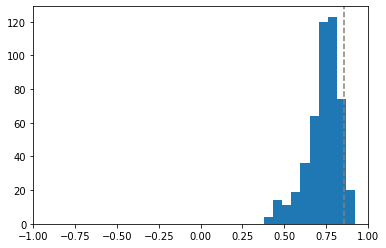

In [71]:
# Compute 95th percentile
def get_95_score(raw_scores):
    return np.percentile(raw_scores, 95)

#Compute 95th percentile and plot distribution
def get_plotted_95_score(raw_scores):
    plt.hist(raw_scores)
    plt.axvline(x=np.percentile(raw_scores, 95), color='gray', linestyle='--')
    plt.xlim((-1, 1))
    return get_95_score(raw_scores)

get_plotted_95_score(ad_f_scores)

In [84]:
#Sorting from the highest to the lowest biasness
np.array(trigrams)[np.argsort(ad_m_scores)[::-1]]

array(['teamtoensure', 'mostifnot', 'asnecessarymaintain',
       'teamstoensure', 'supporttherole', 'talentedgroupof', 'ifnotall',
       'wedemonstrateinformation', 'administrationsupportthe',
       'quicklyandeffectively', 'toworkif', 'itidentitywithin',
       'securityoperationsteam', 'workifthis', 'monitoringverifyingthe',
       'modelwedemonstrate', 'securityoperationssupports',
       'wheretheymaintain', 'meetmostif', 'wanttohear', 'supportteamto',
       'strategypresentit', 'presentitidentity', 'supportteamsto',
       'toensureissues', 'operationalsupportof', 'operationalsupportof',
       'wewantto', 'areresolvedquickly', 'notallof', 'identitywithinthe',
       'andtroubleshootissues', 'rolewillrequire', 'supportmodelwe',
       'wantsyouto', 'tooladministrationsupport', 'ofthecritical',
       'necessarymaintainoperational', 'objectivesandstrategy',
       'toensurecoverage', 'whothecompany', 'withothersupport',
       'threedaysto', 'noticewhothe', 'providelevelother',

## Compacted job ad score function

In [75]:
def get_ad_score(tokens, bag_of_words):
    bias_words, bias_vectors = get_vectors(bag_of_words, False) #existing words and vectors for some bias
    ad_words, ad_vectors = get_vectors(tokens, False)  #existing words and vectors for an ad (first in the list)
    
    trigrams, trigram_ad_vectors = get_trigrams(ad_words, ad_vectors) #trigrams and vectors for them
    
    ad_bias_scores = compute_bias_scores(trigram_ad_vectors, bias_vectors) #computed bias scores
    
    print("ad done")
    
    return get_95_score(ad_bias_scores)

## Job ads distribution for scores

ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done


ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done


ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done


ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done
ad done


TypeError: setp() missing 1 required positional argument: 'obj'

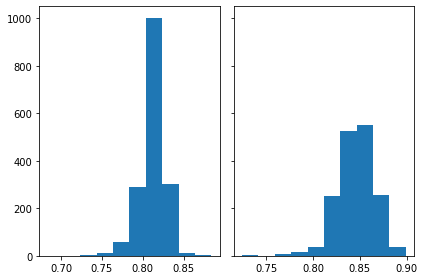

In [76]:
# This one will take quite long (time-wise)
masculine = load_bag_of_words('../../biased-words/masculine_words_suffix.txt')
feminine = load_bag_of_words('../../biased-words/feminine_words_suffix.txt')

overall_m_scores = [get_ad_score(tokenise_ad(ad), masculine) for ad in job_ads]
overall_f_scores = [get_ad_score(tokenise_ad(ad), feminine) for ad in job_ads]

[-1.0, 1.0, -1.0, 1.0]

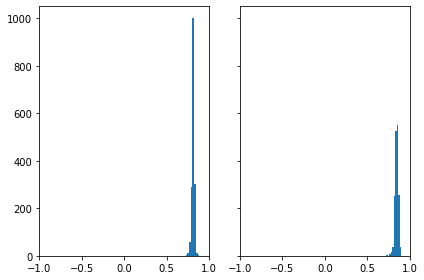

In [77]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(overall_m_scores)
axs[1].hist(overall_f_scores)
plt.setp(axs, xlim=(-1, 1))